In [86]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')

from utils.shift import *
from utils.age import *
from utils.vis import plot_performance_scatter, plot_repr_uncertainty

%load_ext autoreload
%autoreload 2

#aux
clocks = pickle.load(open('subdata/clock_coefs.pkl', 'rb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
######### pair patterns ######

# dfa = ...
# meta = ...

# dfr = ...
# metr = ...

# methclock = ...

# GSE120132 -> GSE60334 (Mouse embryogenesis)

In [44]:
#Aging (Thompson) https://www.aging-us.com/article/101590/text
# met = pickle.load(open('data/GSE120132/GSE120132_metlevs_processed_annotated.pkl', 'rb'))
# dfa = met.drop(['Strain', 'Tissue', 'Age', 'Sex', 'ID'], axis=1).T
# # dfa = dfa.dropna(0)
# meta = met[['Strain', 'Tissue', 'Sex', 'ID']].copy()
# meta['age'] = met['Age']
# dfa = dfa[meta.index]

#Aging (Thompson + Meer)
met = pickle.load(open('data/GSE120132_GSE121141/data.pkl', 'rb'))
dfa = met.drop(['Strain', 'Tissue', 'Age', 'Sex', 'GSE'], axis=1).T
meta = met[['Strain', 'Tissue', 'Sex', 'GSE']].copy()
meta['age'] = met['Age']
dfa = dfa[meta.index]

#Reprogramming + controls (Serrano)
dfr = pd.read_csv('data/GSE60334/data.csv', index_col=0)
metr = pd.read_csv('data/GSE60334/meta.csv', index_col=0)
#filtering & processing
metr = metr[metr['stage'] != 'Adult']
metr['age'] = [float(e.split('E')[1]) for e in metr['stage'].values]
dfr = dfr[metr.index]

# choose tissue from: ['Liver', None]
tissue_age = 'Blood'

if tissue_age is not None:
    meta = meta[meta['Tissue'] == tissue_age]
    dfa = dfa[meta.index].dropna(axis=0)

print('Age, N sites', len(dfa.index))
print('Rep, N sites', len(dfr.index))


# Thompson clock sites
clock = pd.read_csv('subdata/Thompson_sites.csv', )
clock.loc[0, 'Coordinate'] = 0
clock['pos'] = clock['Chromosome'] + '_' + clock['Coordinate'].apply(lambda x: int(x)).astype(str)
clock = clock.set_index('pos')

# Petkovich clock sites
# clock = pd.read_csv('subdata/Petkovich_sites.csv')
# clock['pos'] = clock['Chromosome'] + '_' + clock['Position'].apply(lambda x: int(x)).astype(str)
# clock = clock.set_index('pos')

# Meer clock sites
# clock = pd.read_csv('subdata/Meer_sites.csv')
# clock['pos'] = clock['Chromosome'] + '_' + clock['Position'].apply(lambda x: int(x)).astype(str)
# clock = clock.set_index('pos')

Age, N sites 934041
Rep, N sites 862533


## Select sites using best Lasso model for de-novo clocks

16849 common sites
R2 train = 0.9796540796317689
R2 test = 0.8660089196977163
MAE train = 3.5123067577232194
MAE test = 8.788712459375041
------------------------------


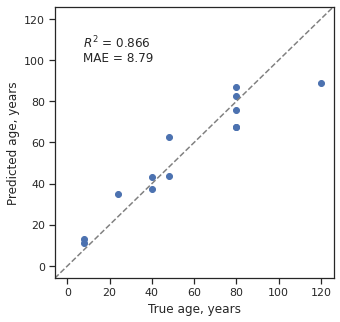

In [67]:
#select de-novo sites
sites = dfr.index.intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)

### TRAINING ###
from sklearn.linear_model import LassoCV
         
model = LassoCV(n_jobs=-1)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)

# write coefs
lasso_sites = model.feature_names_in_[model.coef_ != 0]
lasso_coef = model.coef_[model.coef_ != 0]
clock = pd.DataFrame({'coef':lasso_coef}, index=lasso_sites)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 120))

<AxesSubplot:xlabel='characteristics_ch1.2.cell type', ylabel='lasso_age'>

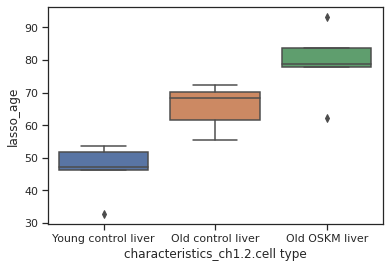

In [68]:
y_rep_predict = model.predict(Xr_clock)
metr['lasso_age'] = y_rep_predict
sns.boxplot(data=metr, x='characteristics_ch1.2.cell type', y='lasso_age')

In [141]:
# clock.index.intersection(dfr.index)

# idx = clock.index

# new_index = []
# for s in idx:
#     c, p = s.split('_')
#     new_index.append(c + '_' + str(int(p)))

# len(dfr.index.intersection(new_index)  )

In [134]:

# filt = ['Fibroblast', 'Transient reprogramming intermediate', 'iPSC']
# cond = metr['Condition'].isin(filt)

# metr = metr[cond]
# dfr = dfr.loc[:, cond]
# methclock = methclock[cond].dropna(axis=1)
# print(metr['Condition'].unique())

# groupr = methclock.groupby('age').mean()

# repday0 = 0
# repday1 = 17

## Methylclock models predict different rejuvenation dynamics

/tmp/ipykernel_47507/3954601975.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


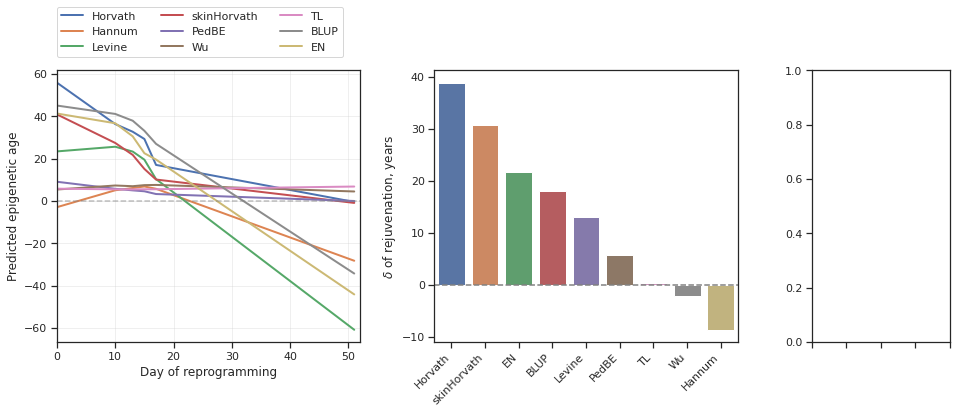

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16,5), gridspec_kw={'width_ratios':[11,11,5]})

#ax0
for c in groupr.columns:
    axes[0].plot(groupr.index, groupr[c], label=c, lw=2)
axes[0].legend(loc=[0.0, 1.05], ncol=3)
axes[0].grid(alpha=0.3)
axes[0].axhline(0, ls='--', alpha=0.5, color='grey')
axes[0].set_xlim([0, 52])
axes[0].set_xlabel('Day of reprogramming')
axes[0].set_ylabel('Predicted epigenetic age')

#ax1
delta_rep = groupr.loc[repday0] - groupr.loc[repday1]
delta_rep = delta_rep.sort_values(ascending=False).to_frame().reset_index()
delta_rep.columns = ['clock', 'delta']

sns.barplot(data=delta_rep, y='delta', x='clock', orient='v', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel(f'$\delta$ of rejuvenation, years')
# axes[1].set_yticks([])
axes[1].axhline(0, color='grey', ls='--')
axes[1].annotate('ElasticNet trained \non different datasets', xy=(10, 92.5), ha='right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

#ax2
# groupr2 = ...
# delta_rep2 = groupr2.loc[0] - groupr2.loc[15]
# delta_rep2 = delta_rep2.sort_values(ascending=False).to_frame().reset_index()
# delta_rep2.columns = ['clock', 'delta']

#call function

# sns.barplot(data=delta_rep2, y='delta', x='clock', orient='v', ax=axes[1], palette='Dark2')
axes[2].annotate('Trained on \nHannum\'s blood \ndataset 71 CpGs', xy=(0, 85))
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

plt.subplots_adjust(wspace=0.3)
plt.show()

## Check covariate shift

In [45]:
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

348 common sites


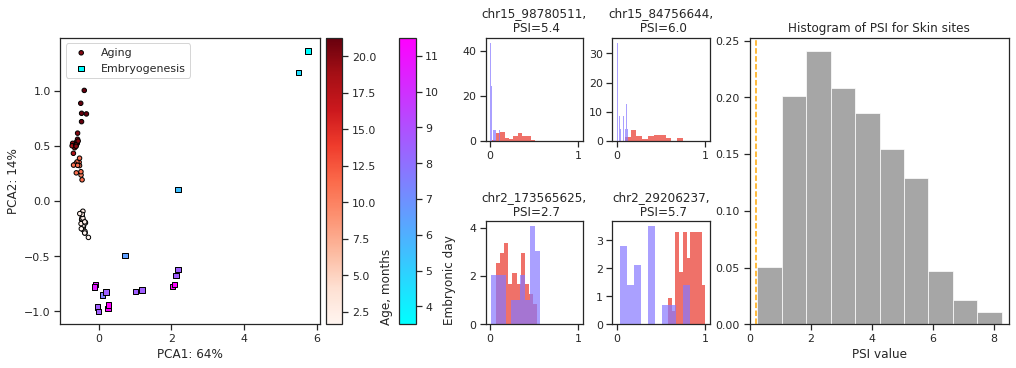

In [48]:
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

pca = PCA(2)
pca.fit(Xa_clock.append(Xr_clock))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

pvar = np.round(pca.explained_variance_ratio_, 2)

fig = plt.figure(figsize=(14, 5), constrained_layout=True)
gs = GridSpec(2, 8, figure=fig, width_ratios=[ 4,4, 0.5, 0.5, 3,3, 4,4]) 
axcb1 = fig.add_subplot(gs[:, 2])
axcb2 = fig.add_subplot(gs[:, 3])
ax0 = fig.add_subplot(gs[:, :2])
ax1 = fig.add_subplot(gs[0, 4])
ax2 = fig.add_subplot(gs[0, 5])
ax3 = fig.add_subplot(gs[1, 4])
ax4 = fig.add_subplot(gs[1, 5])
ax5 = fig.add_subplot(gs[:, 6:])

#cbars
cmap_age = mpl.cm.Reds
cmap_rep = mpl.cm.cool
norm_age = mpl.colors.Normalize(vmin=min(ya), vmax=max(ya))
norm_rep = mpl.colors.Normalize(vmin=min(yr), vmax=max(yr))
cb_age = mpl.colorbar.ColorbarBase(axcb1, cmap=cmap_age, norm=norm_age)
cb_rep = mpl.colorbar.ColorbarBase(axcb2, cmap=cmap_rep, norm=norm_rep)
cb_age.set_label('Age, months', loc='bottom')
cb_rep.set_label('Embryonic day', loc='bottom')

# ax0 - PCA
ax0.set_title('')
z1_plot = ax0.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=20, label='Aging', 
                      edgecolors='black', cmap=cmap_age)
z2_plot = ax0.scatter(Xpr[:, 0], Xpr[:, 1], c=yr, marker='s', s=30, label='Embryogenesis', 
                      edgecolors='black', cmap=cmap_rep)
ax0.set_xlabel(f'PCA1: {int(pvar[0]*100)}%')
ax0.set_ylabel(f'PCA2: {int(pvar[1]*100)}%')
ax0.legend()


#top from Hannum clocks sites by absolute pearson correlation with age
# selected_sites = ['cg16867657', 'cg19283806', 'cg06639320', 'cg07082267']

#top sites from Skin clock based on correlation with age
selected_sites = Xa_clock.corrwith(ya).abs().sort_values(ascending=False).index[:4]

#examples of sites + PSIs
for k, ax_ in enumerate([ax1, ax2, ax3, ax4]): 
    psi = calculate_shift(np.asarray(Xa_clock[selected_sites[k]])[:, None], 
                          np.asarray(Xr_clock[selected_sites[k]])[:, None],
                          metric_type='psi'
                          ).item()
    ax_.hist(Xa_clock[selected_sites[k]], density=True, alpha=0.7, color='#e93529', bins=10, edgecolor='none')
    ax_.hist(Xr_clock[selected_sites[k]], density=True, alpha=0.7, color='#8678ff', bins=10, edgecolor='none')
    ax_.set_title(f'{selected_sites[k]},\n PSI={round(psi, 1)}')
    ax_.set_xlim([-0.05, 1.05])


# ax5 - overall PSI hist
psis = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='psi')

ax5.set_title('Histogram of PSI for Skin sites')
ax5.hist(psis, density=True, alpha=0.7, color='grey')
ax5.axvline(0.2, color='orange', ls='--')
ax5.set_xlim([0, 8.5])
ax5.set_xlabel('PSI value')
plt.show()

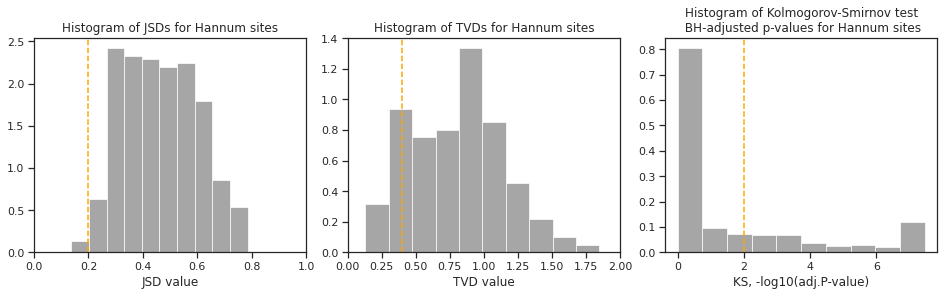

In [49]:
#supplement
from statsmodels.stats.multitest import multipletests

fig = plt.figure(figsize=(13, 4), constrained_layout=True)
gs = GridSpec(1, 3, figure=fig) 
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# ax5 - overall PSI hist
psis = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='jsd')

ax0.set_title('Histogram of JSDs for Hannum sites')
ax0.hist(psis, density=True, alpha=0.7, color='grey')
ax0.axvline(0.2, color='orange', ls='--')
ax0.set_xlim([0, 1])
ax0.set_xlabel('JSD value')

psis = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='tvd')

ax1.set_title('Histogram of TVDs for Hannum sites')
ax1.hist(psis, density=True, alpha=0.7, color='grey')
ax1.axvline(0.4, color='orange', ls='--')
ax1.set_xlim([0, 2])
ax1.set_xlabel('TVD value')

ks, ksp = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='ks')
kspa = multipletests(ksp, method='hs')[1]
ax2.set_title('Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Hannum sites')
ax2.hist(-np.log10(kspa), density=True, alpha=0.7, color='grey')
ax2.axvline(-np.log10(0.01), color='orange', ls='--')
#ax2.set_xlim([0, 1])
ax2.set_xlabel('KS, -log10(adj.P-value)')
plt.show()

## Inversed Train Test Procedure (ITTP)

In [50]:
# case with dim X > 1
# clock = clocks['Hannum clock (71 CpGs)']
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)

348 common sites


Step 1 results:
R2 train = 0.988
MAE train = 0.641
R2 test = 0.909
MAE test = 2.001
------------------------------
Step 2 results:
R2 train = 0.9
MAE train = 2.179
R2 test = 0.841
MAE test = 2.285
------------------------------


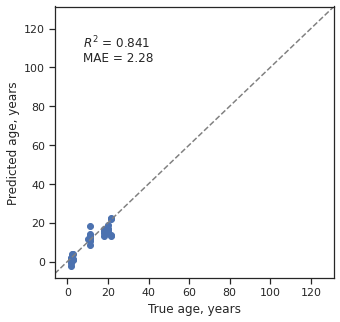

In [51]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 X_test, y_test=y_test, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(0, 125))

Step 1 results:
R2 train = 0.999
MAE train = 0.152
------------------------------
Step 2 results:
R2 test = -5.442
MAE test = 18.265
------------------------------


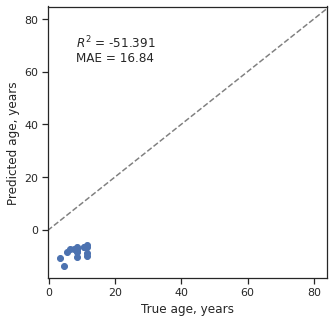

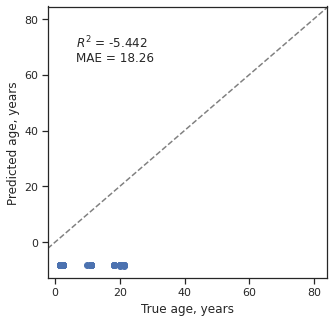

In [52]:
(y_train_predict_step1, 
y_test_predict_step1, 
y_train_predict_step2,
y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 Xa_clock, ya, 
                                 Xr_clock, y_test=None, 
                                 params={"max_iter":3000},
                                 verbose=1)

plot_performance_scatter(yr, y_test_predict_step1, eq_bounds=(35, 80))
plt.show()
plot_performance_scatter(ya, y_test_predict_step2, eq_bounds=(35, 80))

## Epistemic uncertainty estimation with Gaussian Process Regressor

### univariate case

In [70]:
# case with dim X > 1
# clock = clocks['Hannum clock (71 CpGs)']
clock = clocks['Skin clock (391 CpGs)']
sites = clock.index.intersection(dfr.index).intersection(dfa.index)

sites_ = dfa.loc[sites].T.corrwith(ya).sort_values(ascending=False).index[[0]]
#sites_ = ['cg16867657'] #'cg16867657', 'cg06639320', 'cg22454769', 'cg24079702', 'cg14361627']

Xa_clock = dfa.loc[[sites_[0]]].T
Xr_clock = dfr.loc[[sites_[0]]].T

ya = meta['age']
yr = metr['age'].values

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(35, 80))

IndexError: index 0 is out of bounds for axis 0 with size 0

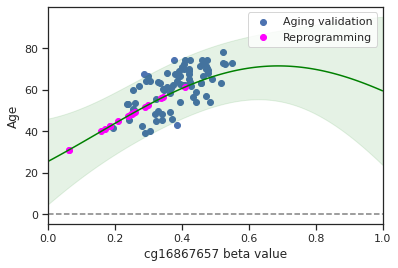

In [ ]:
idsort = np.argsort(X_test.iloc[:, 0]).values
x_test = X_test.iloc[idsort, :]
y_test_predict, y_test_std = model.predict(x_test, return_std=True)

x_test2 = np.linspace(0, 1, 100)[:, None]
y_test_predict2, y_test_std2 = model.predict(x_test2, return_std=True)
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plt.scatter(x_test.iloc[:, 0], y_test[idsort], label='Aging validation')
# plt.scatter(x_test.iloc[:, 0], y_test_predict)
#plt.fill_between(x_test.iloc[:, 0], y_test_predict + 2*y_test_std, y_test_predict - 2*y_test_std, alpha=0.5)
plt.plot(x_test2[:, 0], y_test_predict2,color='green')
plt.fill_between(x_test2[:, 0], 
                 y_test_predict2 + 2*y_test_std2, 
                 y_test_predict2 - 2*y_test_std2, 
                 alpha=0.1, color='green')

plt.scatter(Xr_clock.iloc[:, 0], y_test_predict_r, color='magenta', label='Reprogramming')
plt.xlim([0, 1.0])
plt.axhline(0, color='grey', ls='--')
plt.ylabel('Age')
plt.xlabel('cg16867657 beta value')
plt.legend()
plt.show()

### multivariate case

348 common sites
R2 train = 0.9999732421227854
R2 test = 0.9297625161448708
MAE train = 0.03077638989386256
MAE test = 1.9100374443096892
------------------------------
Resulting kernel: 15.3**2 * RBF(length_scale=3.82) + WhiteKernel(noise_level=0.1)
Resulting kernel (full): 11.6**2 * RBF(length_scale=2.81) + WhiteKernel(noise_level=0.1)


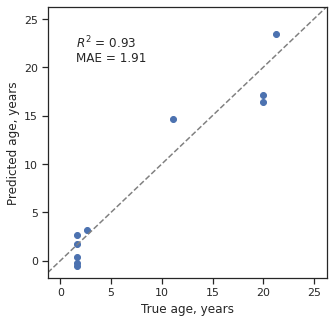

In [54]:
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age'] 
yr = metr['age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.20, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 25))

model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(Xa_clock, ya)
print("Resulting kernel (full):", model.kernel_)

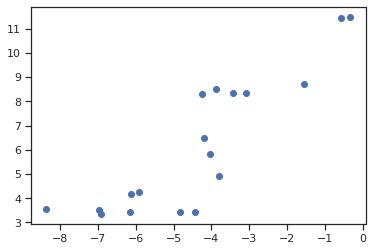

In [60]:
plt.scatter(y_test_predict_r, y_test_std_r)

Avg uncertainty std: 6.196892004173633
P-value of rejuvenation effect between 3.5 and 7.5 days is 0.6273188555165876
P-value of rejuvenation effect between 7.5 and 10.5 days is 0.7177279669381533


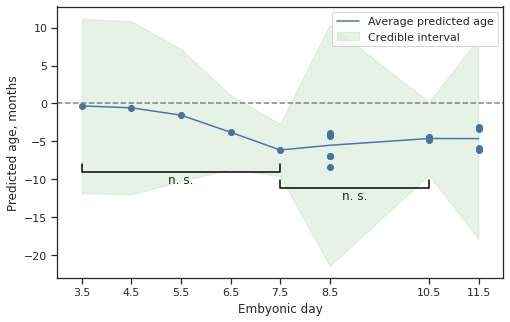

In [89]:
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plot_repr_uncertainty(yr.values, y_test_predict_r, y_test_std_r, 
                      days=[(3.5, 7.5), (7.5, 10.5)],
                      nstd=1, dh=[0.05, 0.11], barh=0.03,
                      ylabel='Predicted age, months',
                      xlabel='Embyonic day'
                      )


R2 test = 0.19012388645586742
MAE test = 13.725687275547594


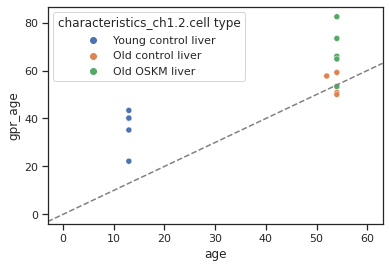

In [89]:
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

metr['gpr_age'] = y_test_predict_r


sns.scatterplot(data=metr, x='age', y='gpr_age', hue='characteristics_ch1.2.cell type')
plt.axline([0,0], [60,60], ls='--', color='grey');

print(f'R2 test = {r2_score(yr, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(yr, y_test_predict_r)}')

<AxesSubplot:xlabel='characteristics_ch1.2.cell type', ylabel='gpr_age'>

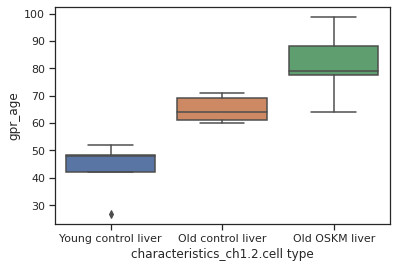

In [84]:
sns.boxplot(data=metr, x='characteristics_ch1.2.cell type', y='gpr_age')

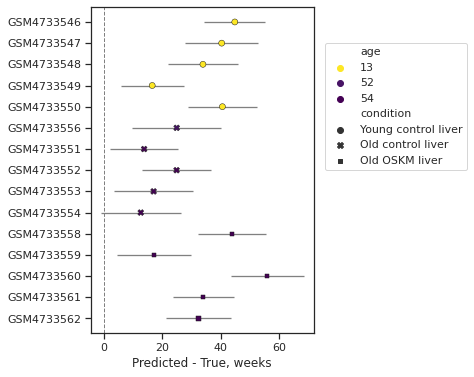

R2 test = -1.906585397510526
MAE test = 30.195112487449116


In [81]:
import matplotlib as mpl
import matplotlib.cm as cm

#prediction of test dataset
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

metr['gpr_age'] = y_test_predict_r
metr['gpr_std'] = y_test_std_r
metr['condition'] = metr['characteristics_ch1.2.cell type']
metr['diff'] = metr['gpr_age'] - metr['age']
   
fig, ax = plt.subplots(1,1, figsize=(4, 6))
metr_ = metr.copy().reset_index().sort_values('age')


ax.errorbar(x=metr_['diff'], y=metr_['index'], xerr=metr_['gpr_std'], linewidth=0, elinewidth=1.3, color='grey')

sns.scatterplot(
    data=metr_, x="diff", y='index',  
    marker="o",
    hue='age',
    edgecolor='k',
    style='condition',
    palette=mpl.cm.viridis_r,
    zorder=2,
    ax=ax
)


ax.axvline(0, ls='--', lw=1, color='grey')
ax.set_xlabel('Predicted - True, weeks')
ax.set_ylabel('')
ax.legend(loc=[1.05, 0.5])
plt.show()

print(f'R2 test = {r2_score(yr, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(yr, y_test_predict_r)}')